# Introduction

This workbook fits a Gaussian Process model to the Random and Sobol data. 

In [2]:
import GPy
import pandas as pd
import patsy as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pymc3 as pm
import matplotlib.ticker as tk

import pickle

In [3]:
mod = pickle.load(open('results/ppo_tor_bayesian_model.p', 'rb'))
gp = mod['gp']
trace = mod['trace']
model = mod['model']

In [72]:
df_trace = pd.DataFrame({x : trace.get_values(x) for x in trace.varnames if x[-5:]!='log__'})
df_trace.rename(columns={'l_basiskappa_angle': r'$\kappa$ torsion', 'l_basisca_cont': r'$C \alpha$ contact', 
                        'l_basisclose-h_cont': 'Heavy contact', 'l_basisclose_cont': 'Closest contact', 
                        'l_basisdrid': 'DRID', 'l_n_s': '$n$', 'l_t_s': r'$\tau$', 
                        'l_basishb_pairs': 'BH distance', 'l_basisppo_tor': 'Backbone torsions', 
                        'l_basisall_tor': 'All torsions', 'l_basisalpha_angle': r'$C \alpha$ torsion', 
                        'l_m_s': '$m$', 'eta': r'$\eta$', 'sigma_n': r'$\sigma_n$'}, inplace=True)



len_labs = [x for x in list(df_trace.columns) if x not in [r'$\eta$', r'$\sigma_n$']]

relevance = pd.DataFrame(1/df_trace.loc[:, len_labs].values, columns=len_labs)
relevance_m = relevance.melt(var_name='Hyperparameter', value_name='Relevance')

y_order = relevance_m.groupby('Hyperparameter').median().reset_index().sort_values(by='Relevance')['Hyperparameter'].values
cont_hyperparams = [r'$\tau$', r'$m$', r'$n$']
y_order = [x for x in y_order if x not in cont_hyperparams]
y_order = y_order + cont_hyperparams

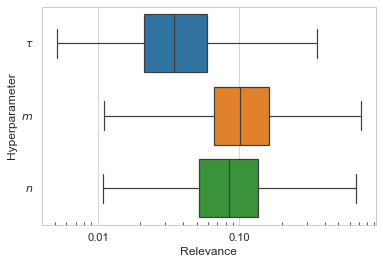

In [76]:

with sns.plotting_context('paper', font_scale=1.25):
    sns.set_style('whitegrid')
#     g = sns.FacetGrid(data=relevance_m, hue='Hyperparameter')
#     g.map(sns.distplot, 'Relevance')
    ax = sns.boxplot(data=relevance_m, x='Relevance', y='Hyperparameter', whis='range', order=y_order)
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(tk.StrMethodFormatter('{x:4.2f}'))
    ax.xaxis.set_minor_locator(tk.LogLocator(base=10.0, subs='auto', numdecs=4))
    ax.tick_params(which='minor', axis='x', bottom=True, direction='in')
    plt.savefig('figures/ppo_tor_gp_bayes_relevance.png', dpi=450 )

In [77]:
all_params = relevance.join(df_trace.loc[:, [r'$\eta$', r'$\sigma_n$']])

all_params.melt(var_name='Parameter').groupby('Parameter')['value'].\
aggregate(**{"Median": lambda x: "{:4.2f}".format(np.median(x)), 
             "95% CI": lambda x: "({0:4.2f}, {1:4.2f})".format(np.quantile(x, 0.025),np.quantile(x, 0.975))}).\
reset_index().\
to_csv('results/ppo_gp_bayes_posterior.csv', index=False)
